# Simplest ETU3 model

3 _ \
2 _ \
1 _ _ b \
0 _ _ a\
...A S...

## Study of delivered UC power for various excitation pulse profiles 

$P_{avg} = P_{peak} \cdot \frac{\Delta t}{T}$

Studies: 
$P_{avg} = 0.5 W/cm^2$

1. CW
2. $P_{peak} = 1 W/cm^2$, $T \in \{0.001, 0.005, 0.01, 0.02\}$
3. $T = 0.02 s$, $\Delta t \in \{0.01, 0.005, 0.003, 0.001\}$
4. $\Delta t = 0.005$, $P_{peak} \in \{2, 5, 10, 50\}$

In [1]:
%matplotlib notebook
import matplotlib.pyplot as pl
import numpy as np
from scipy import constants
from sympy import init_session, solve, lambdify, Symbol, symbols, Eq
from sympy.physics.mechanics import dynamicsymbols
import sys
sys.path.append('../scripts/')
sys.path.append('../utils/')
from virtualab import Sample, Laser, Experiment
import utils

## Create new experiment

In [2]:
experiment = Experiment()

### Prepare laser

In [43]:
laser = Laser(wavelength=976e-9, mode='pulse')

# Constant average power
P_avg = 0.5 # W/cm^-2

## 0th Study: CW
# T = 0.01 
# Deltat = 0.01
# Pp = P_avg

## 2nd Study: Pulse with T = {0.001, 0.005, 0.01, 0.02}
# Pp = 1 # W/cm^2
# dutycycle = P_avg / Pp
# T = 0.0004
# Deltat = T * dutycycle
 
## 3rd Study: Pulse with Deltat = {0.01, 0.005, 0.003, 0.001}
# T = 0.02
# Deltat = 0.0002
# dutycycle = Deltat / T
# Pp = P_avg / dutycycle

## 4th Study: Pulse with Ppeak = {1, 2, 5, 10, 50}
Deltat = 0.005
Pp = 50 # W/cm^2
dutycycle = P_avg / Pp
T = Deltat / dutycycle


laser.basePower = 0.0
laser.powerAtPeak = Pp  # W/cm^-2
laser.period = T
laser.periodOn = Deltat # delta t of duty cycle
laser.nCycles = 2
laser.samplingRate = 1e5 # number of points per second

### Prepare sample

$NaY_{(1-x-y)}F_4:Yb_{x}Tm_{y}$

In [44]:
electronicPop_S, electronicPop_A = utils.REConc(x=0.12, y=0.001)

NYb=1.5322875172623467e+21, NTm=1.276906264385289e+19


#### Rate equations and constants

In [45]:
constants.h * constants.c / laser.wavelength

2.0352928864230824e-19

In [46]:
w2 = 1.7e-1*6.2e-16*58/4/10
w2

1.5283e-16

In [47]:
# Population densities 
sample = Sample(name='ETU3-simple-model')

Na, Nb, N0, N1, N2, N3 = dynamicsymbols("N_a N_b N_0 N_1 N_2 N_3")

# Total population
Nsens, Nact = symbols('N_sens N_act')
sample.props.update({Nsens: electronicPop_S})
sample.props.update({Nact: electronicPop_A})

# Energy transfer (W2 from experimental data)
W0, W1, W2 = symbols('W_0 W_1 W_2')
sample.props.update({W0: 1.6e-18}) # energy transfer upconversion rate in s^-1
sample.props.update({W1: 6.2e-16}) # energy transfer upconversion rate in s^-1
sample.props.update({W2: 1.52e-16}) # energy transfer upconversion rate in s^-1

# Decay rates (Delgado 2015)
Rba, R10, R20, R30 = symbols('R_{ba} R_{10} R_{20} R_30')
sample.props.update({Rba: 1 / 1.32e-3}) # s^-1
sample.props.update({R10: 1 / 58e-6}) # s^-1
sample.props.update({R20: 1 / 10e-6}) # s^-1
sample.props.update({R30: 1 / 675e-6}) # s^-1

# Cross section
sigmaab = symbols('sigma_ab')
sample.props.update({sigmaab: 1.69e-20}) # cm^-2

# constants
h, nu = symbols('h nu')
sample.props.update({h: constants.h}) # Planks constant
sample.props.update({nu: constants.c / laser.wavelength}) # frequency of excitation

# time
t = symbols('t')

# power density
p = symbols('rho')

# Rate equations
NaRate = Eq(Na.diff(t), Rba * Nb - sigmaab * p / (h * nu) * (Nsens - Nb))
NbRate = Eq(Nb.diff(t), - NaRate.rhs)

N0Rate = Eq(N0.diff(t), R30 * N3 + R20 * N2 + R10 * N1 - W0 * Nb * N0)
N1Rate = Eq(N1.diff(t), W0 * Nb * N0 - W1 * Nb * N1 - R10 * N1)
N2Rate = Eq(N2.diff(t), W1 * Nb * N1 - W2 * Nb * N2 - R20 * N2)
N3Rate = Eq(N3.diff(t), W2 * Nb * N2 - R30 * N3)

# Bind model to sample
sample.model([(Nb, NbRate, 0), (N0, N0Rate, sample.props[Nact]), (N1, N1Rate, 0), (N2, N2Rate, 0), (N3, N3Rate, 0)])
sample.boundaryConds = {Nb: [0, sample.props[Nsens]], N0: [0, sample.props[Nact]], N1: [0, sample.props[Nact]], N2: [0, sample.props[Nact]], N3: [0, sample.props[Nact]]}


In [48]:
# Rate equations used on the simulations
sample.showequations()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Run experiment

In [49]:
experiment.new(laser, sample)

Laser on 🚨:  51%|▌| 50871/99999 [03:

N_0(t) = 1.2769062738129058e+19 outside boundary


#### Add ground states 

In [50]:
# N_0
# experiment.sample.data['N_0'] = experiment.sample.props[Nact] - (
#     experiment.sample.data['N_1'] + experiment.sample.data['N_2'] + experiment.sample.data['N_2']
# )
# N_a
experiment.sample.data['N_a'] = experiment.sample.props[Nsens] - experiment.sample.data['N_b']

In [51]:
experiment.sample.data

,t,power,N_b,N_0,N_1,N_2,N_3,N_a
0,0.000000,0.0,0.000000e+00,1.276906e+19,0.000000e+00,0.000000e+00,0.000000e+00,1.532288e+21
1,0.000010,0.0,0.000000e+00,1.276906e+19,0.000000e+00,0.000000e+00,0.000000e+00,1.532288e+21
2,0.000020,0.0,0.000000e+00,1.276906e+19,0.000000e+00,0.000000e+00,0.000000e+00,1.532288e+21
3,0.000030,0.0,0.000000e+00,1.276906e+19,0.000000e+00,0.000000e+00,0.000000e+00,1.532288e+21
4,0.000040,0.0,0.000000e+00,1.276906e+19,0.000000e+00,0.000000e+00,0.000000e+00,1.532288e+21
...,...,...,...,...,...,...,...,...
50868,0.508685,0.0,1.101930e+16,1.276906e+19,1.354833e+13,9.256009e+08,2.285526e+09,1.532276e+21
50869,0.508695,0.0,1.093582e+16,1.276906e+19,1.344573e+13,9.116327e+08,2.251681e+09,1.532277e+21
50870,0.508705,0.0,1.085297e+16,1.276906e+19,1.334391e+13,8.978753e+08,2.218337e+09,1.532277e+21
50871,0.508715,0.0,1.077075e+16,1.276906e+19,1.324286e+13,8.843255e+08,2.185487e+09,1.532277e+21


<IPython.core.display.Javascript object>


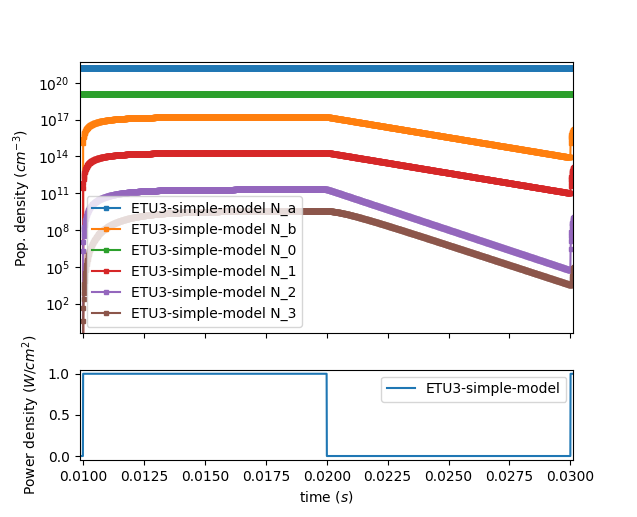

In [14]:
_ = experiment.plot(x='t', yList=['N_a', 'N_b', 'N_0', 'N_1', 'N_2', 'N_3'])

In [53]:
experiment.save('pulse_study_etu3_Pavg_deltat_cnt_Ppeak_50')

Data saved: ..\output\pulse_study_etu3_Pavg_deltat_cnt_Ppeak_50.csv!


In [10]:
experiment.load('pulse_study_etu3_Pavg_duty_cnt_T_002')

## Population of the states

<IPython.core.display.Javascript object>


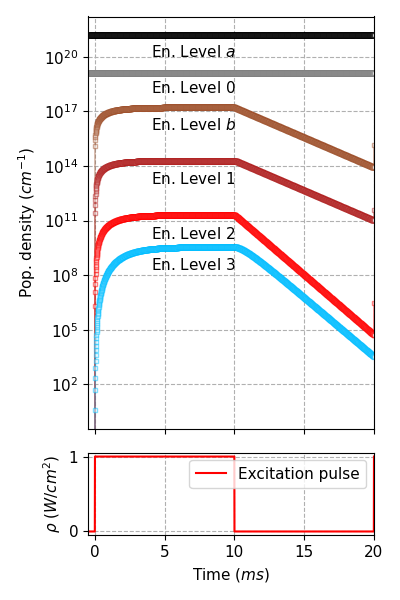

In [160]:
pl.rcParams.update({'font.size': 11})

fig, axs = pl.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [5, 1]}, figsize=(4, 6))

T = experiment.laser.period / 2
time = 1000 * (experiment.sample.data['t'] - T)
timeText = (0.014 - T) * 1000

axs[0].semilogy(time, experiment.sample.data['N_a'], '-s', color='k', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $a$')
axs[0].text(timeText, 1e20, 'En. Level $a$')
axs[0].semilogy(time, experiment.sample.data['N_0'], '-s', color='gray', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $0$')
axs[0].text(timeText, 1e18, 'En. Level $0$')

axs[0].semilogy(time, experiment.sample.data['N_b'], '-s', color='sienna', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $b$')
axs[0].text(timeText, 1e16, 'En. Level $b$')

axs[0].semilogy(time, experiment.sample.data['N_1'], '-s', color='firebrick', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $1$')
axs[0].text(timeText, 1e13, 'En. Level $1$')

axs[0].semilogy(time, experiment.sample.data['N_2'], '-s', color='red', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $2$')
axs[0].text(timeText, 1e10, 'En. Level $2$')

axs[0].semilogy(time, experiment.sample.data['N_3'], '-s', color='deepskyblue', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $3$')
axs[0].text(timeText, 2e8, 'En. Level $3$')
axs[0].grid(linestyle='--', linewidth=0.8)
# axs[0].legend()

axs[0].set_ylabel('Pop. density $(cm^{-1})$')

axs[1].plot(time, experiment.sample.data['power'], '-', color='red', lw=1.5, label='Excitation pulse')
axs[1].set_xlabel('Time $(ms)$')
axs[1].set_ylabel(r'$\rho$ $(W/cm^2)$')
axs[1].grid(linestyle='--', linewidth=0.8)
axs[1].legend()



pl.xlim([-0.5, 20])
pl.tight_layout()

<IPython.core.display.Javascript object>


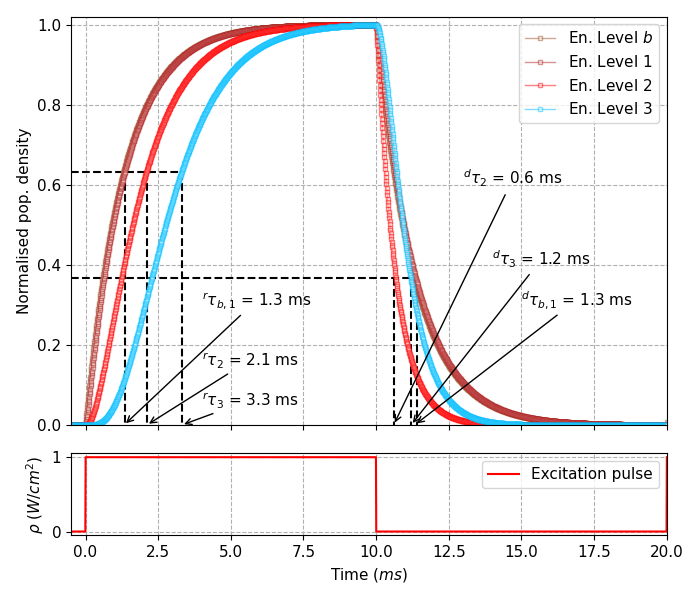

In [162]:
pl.rcParams.update({'font.size': 11})

fig, axs = pl.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [5, 1]}, figsize=(7, 6))

T = experiment.laser.period / 2
time = 1000 * (experiment.sample.data['t'] - T)
timeText = (0.014 - T) * 1000

arrowProps = dict(facecolor ='k', arrowstyle = "->")

# raise time
axs[0].plot([-0.5, 3.32], [1-np.exp(-1), 1-np.exp(-1)], 'k--')

axs[0].plot([3.32, 3.32], [1-np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^r\tau_3$ = 3.3 ms', xy=(3.3, 0), xytext=(4, 0.05), arrowprops = arrowProps)
axs[0].plot([2.11, 2.11], [1-np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^r\tau_2$ = 2.1 ms', xy=(2.1, 0), xytext=(4, 0.15), arrowprops = arrowProps)
axs[0].plot([1.36, 1.36], [1-np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^r\tau_{b,1}$ = 1.3 ms', xy=(1.32, 0), xytext=(4, 0.3), arrowprops = arrowProps)

# decay time
axs[0].plot([-0.5, 11.41], [np.exp(-1), np.exp(-1)], 'k--')

axs[0].plot([10.6, 10.6], [np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^d\tau_2$ = 0.6 ms', xy=(10.6, 0), xytext=(13, 0.6), arrowprops = arrowProps)
axs[0].plot([11.2, 11.2], [np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^d\tau_3$ = 1.2 ms', xy=(11.2, 0), xytext=(14, 0.4), arrowprops = arrowProps)
axs[0].plot([11.4, 11.4], [np.exp(-1), -1], 'k--')
axs[0].annotate(r'$^d\tau_{b,1}$ = 1.3 ms', xy=(11.32, 0), xytext=(15, 0.3), arrowprops = arrowProps)


axs[0].plot(time, experiment.sample.data['N_b'] / experiment.sample.data['N_b'].max(), '-s', color='sienna', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $b$')
# axs[0].text(timeText, 1e16, 'En. Level $b$')

axs[0].plot(time, experiment.sample.data['N_1'] / experiment.sample.data['N_1'].max(), '-s', color='firebrick', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $1$')
# axs[0].text(timeText, 1e13, 'En. Level $1$')

axs[0].plot(time, experiment.sample.data['N_2'] / experiment.sample.data['N_2'].max(), '-s', color='red', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $2$')
# axs[0].text(timeText, 1e10, 'En. Level $2$')

axs[0].plot(time, experiment.sample.data['N_3'] / experiment.sample.data['N_3'].max(), '-s', color='deepskyblue', ms=3, mfc='w', alpha=.5, lw=1, label='En. Level $3$')
# axs[0].text(timeText, 2e8, 'En. Level $3$')


axs[0].grid(linestyle='--', linewidth=0.8)
axs[0].legend()

axs[0].set_ylabel('Normalised pop. density')

axs[1].plot(time, experiment.sample.data['power'], '-', color='red', lw=1.5, label='Excitation pulse')
axs[1].set_xlabel('Time $(ms)$')
axs[1].set_ylabel(r'$\rho$ $(W/cm^2)$')
axs[1].grid(linestyle='--', linewidth=0.8)
axs[1].legend()

pl.xlim([-0.5, 20])
axs[0].set_ylim([0, 1.02])
pl.tight_layout()